In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.font_manager
import seaborn as sns
from fitter import Fitter

## Pre_function

In [2]:
def dropna(df,ran):
    # ran slice_parameter ex:[i for i in range(6)]
    df1 = df.iloc[:,ran]
    df1 = df1.dropna()
#     x = df1.iloc[:,0].to_numpy()
#     y = df1.iloc[:,1].to_numpy()
    ar= df1.to_numpy()
    return ar

In [3]:
def reorder(li,rever= 0):
    # li 不可有空值
    y=[]
    for i in range(len(li)):
        y.append(li[i])
    reorder = sorted(range(len(li)), key = lambda ii: y[ii], reverse=rever)
    y = [y[ii] for ii in reorder]
    return y

In [4]:
def loglogplot(x,y,labelx="LogPop",labely="LogArea"):
    plt.style.use('ggplot')
    xd,yd=np.log10(x),np.log10(y)
    # make the scatter plot
    fig, ax = plt.subplots(figsize=(5,4))

    ax.set_yscale("log")
    ax.set_xscale("log")
    #ax.set_ylim(1e1,10**3.4)
    #ax.set_xlim(10**(-0.1),10**(2.5))
    # determine best fit line
    par = np.polyfit(xd, yd, 1,full=True)

    slope=par[0][0]
    intercept=par[0][1]

    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]
    ax.plot([10**xx for xx in xl],[10**yy for yy in yl], '-m')

    # coefficient of determination, plot text
    variance = np.var(yd)#方差
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])#残差

    Rsqr = np.round(1-residuals/variance, decimals=2)
    #ax.text(0.3*max(x),1.2*max(y),r'$R^2 ={0.2f} \n Slope={0.2f}'.format{Rsqr,slope.round(2)}, fontsize=15)
    ax.text(min(x),1.1*max(y),'%s =%0.2f\nSlope=%0.2f\nIntercept=%0.2f'%("$\sf{R^2}$",Rsqr,slope.round(2),intercept), fontsize=8)
    print(variance,residuals)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    
    # error bounds
    yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)]
    par = np.polyfit(xd, yerr, 2, full=True)
    erro_x2 = par[0][0]
    erro_x1 = par[0][1]
    erro_x0 = par[0][2]
    yerrUpper = [(xx*slope+intercept)+(erro_x2*xx**2 + erro_x1*xx + erro_x0) for xx,yy in zip(xd,yd)]
    yerrLower = [(xx*slope+intercept)-(erro_x2*xx**2 + erro_x1*xx + erro_x0) for xx,yy in zip(xd,yd)]
    print(erro_x2, erro_x1, erro_x0)
    
#     ax.plot([10**xx for xx in xd],[10**yy for yy in yerrLower], 'm')
#     ax.plot([10**xx for xx in xd],[10**yy for yy in yerrUpper], 'm')
    ax.scatter(x, y, s=10, alpha=1, marker='h',color="orangered")

    yline = [slope*xl[0] + intercept,xl[1] + intercept]
    #yline2 = [xl[0] + intercept,slope*xl[1] + intercept]
    ax.plot([10**xx for xx in xl],[10**yy for yy in yline], '--m')
    #ax.plot([10**xx for xx in xl],[10**yy for yy in yline2], '--m')
    ax.text(250,660, "Slope=1", size = 5,\
             family = "fantasy", color = "r", style = "italic", weight = "light",\
             )#bbox = dict(facecolor = "r", alpha = 0.2)
    return slope,ax

In [5]:
def getslope(x,y):
    xd,yd=np.log10(x),np.log10(y)
    par = np.polyfit(xd, yd, 1,full=True)
    slope=par[0][0]
    intercept=par[0][1]
    variance = np.var(yd)#方差
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])#残差
    Rsqr = np.round(1-residuals/variance, decimals=2)
    #print(type(slope))
    return slope,intercept,Rsqr

In [6]:
def generate_rand(mean,std,size,seedNum):
    np.random.seed(seedNum)
    ar = np.random.normal(mean,std,size)
    return ar 

In [7]:
def excess_incre(x,y,ar,slope):
    # delta x 
    excessIncre = 1.2
    xr = [xx*ar[np.random.randint(q)]-xx for xx in x]
    yr = [excessIncre*(float(slope)*P[0] + P[1]) for P in zip(xr,y)]
    return xr+x,yr

In [8]:
def var_excess_incre(x,y,ar,slope,er,q):
    xr = [xx*ar[np.random.randint(q)]-xx for xx in x]
    yr = [er[np.random.randint(q)]*(float(slope)*P[0] + P[1]) for P in zip(xr,y)]
    return xr+x,yr

In [9]:
def var_excess_incre4(x,y,ar,slope,er,q):
    xr = [xx*ar[np.random.randint(q)]-xx for xx in x]
    yr = [er[np.random.randint(q)]
          *ar[np.random.randint(q)]**(float(slope))*P 
          for P in y]
    return xr+x,yr

In [10]:
def var_excess_incre3(x,y,ar,slope,er,q):
    xr = [xx*ar[np.random.randint(q)]-xx for xx in x]
    yr = [er[np.random.randint(q)]
          *10**(float(slope)*np.log10(ar[np.random.randint(q)]) + np.log10(P)) 
          for P in y]
    return xr+x,yr

In [11]:
def var_excess_incre2(x,y,ar,slope,er,q):
    delta = ar[np.random.randint(q)]
    xr = [xx*delta-xx for xx in x]
    eta = er[np.random.randint(q)]
    yr = [10**(eta*(float(slope)*delta + np.log10(P))) for P in y]
    return xr+x,yr

In [12]:
def del_nagative(x2,y2):
    xx,yy=[],[]
    for i in range(len(y2)):
        if y2[i]>0.0001 and x2[i]>0.0001:
            xx.append(x2[i])
            yy.append(y2[i])
    return xx,yy

## exp

0.13081706109598865 0.012310793681442979
0.028026341068329737 -0.12233802043237227 0.2119255753592895


(0.9069832451489056, <matplotlib.axes._subplots.AxesSubplot at 0x23fbabcd940>)

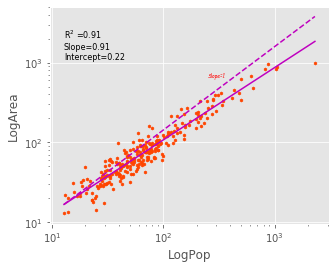

In [23]:
df = pd.read_excel("Pop_Area.xlsx",sheet_name = "Sheet3",index_col="ID")
ls  = dropna(df,[3,4])
x=ls[:,0]
y=ls[:,1]
loglogplot(x,y)

In [45]:
stx = 1
meanx = 1.28
meany = 1.21

In [46]:
sty= 0.00001
q = 3000
xp = generate_rand(1.2,stx,q,4)# 水平增量
yp= generate_rand(1.2,sty,q,8)# 超额增量

0.24224746040893003 0.1897991493506307
0.024264983471260857 -0.11260548672494437 0.448602804833361


F:\Miniconda\conda64\envs\py37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


0.22

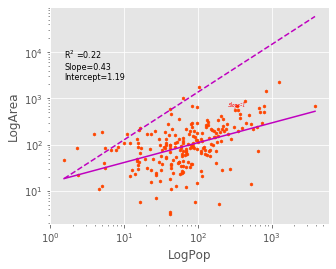

In [47]:
slope,i,r= getslope(x,y)
x2,y2 = var_excess_incre4(x,y,xp,slope,yp,q)
xx,yy = del_nagative(x2,y2)
s,i,r = getslope(xx,yy)
loglogplot(xx,yy)
r

0.13081667196928592 0.01231123983459827
0.028014817219973422 -0.12673011166482814 0.2217441821969927


0.91

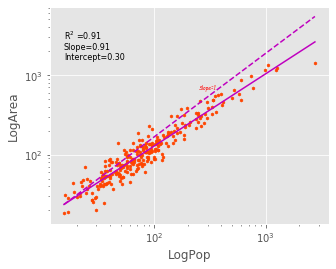

In [27]:
slope,i,r= getslope(x,y)
x2,y2 = var_excess_incre3(x,y,xp,slope,yp,q)
xx,yy = del_nagative(x2,y2)
loglogplot(xx,yy)
r

## num

In [92]:
df = pd.read_excel("Pop_Area.xlsx",sheet_name = "Sheet3",index_col="ID")
ls  = dropna(df,[3,4])
x=ls[:,0]
y=ls[:,1]
slope,i,r= getslope(x,y)

In [93]:
df = pd.DataFrame([],columns = ["meanx","meany","stx","sty","s","i","r"])
meanx = 1.28
meany = 1.21
for stx in np.logspace(-3,0,10):
    for sty in np.logspace(-5,0,100):
        print(stx,sty,meanx,meany)
        s,i,r =[],[],[]
        for repeat in range(10):
            n = 3000
            xp = generate_rand(meanx,stx,n,repeat)# 水平增量
            yp = generate_rand(meany,sty,n,100-repeat)#超额增量
            x2,y2 = var_excess_incre4(x,y,xp,slope,yp,n)
            xx,yy = del_nagative(x2,y2)
            ss,ii,rr = getslope(xx,yy)
            s.append(ss)
            i.append(ii)
            r.append(rr)
        sm = np.mean(s)
        im = np.mean(i)
        rm = np.mean(r)
        s = pd.Series({"meanx":meanx,"meany":meany,"stx":stx,"sty":sty,"s":sm,"i":im,"r":rm})
        df = df.append(s,ignore_index=True)

0.001 1e-05 1.28 1.21
0.001 1.1233240329780266e-05 1.28 1.21
0.001 1.2618568830660211e-05 1.28 1.21
0.001 1.4174741629268048e-05 1.28 1.21
0.001 1.5922827933410938e-05 1.28 1.21
0.001 1.7886495290574353e-05 1.28 1.21
0.001 2.0092330025650458e-05 1.28 1.21
0.001 2.2570197196339216e-05 1.28 1.21
0.001 2.5353644939701114e-05 1.28 1.21
0.001 2.848035868435799e-05 1.28 1.21
0.001 3.199267137797385e-05 1.28 1.21
0.001 3.5938136638046256e-05 1.28 1.21
0.001 4.037017258596558e-05 1.28 1.21
0.001 4.534878508128582e-05 1.28 1.21
0.001 5.0941380148163754e-05 1.28 1.21
0.001 5.72236765935022e-05 1.28 1.21
0.001 6.428073117284319e-05 1.28 1.21
0.001 7.220809018385456e-05 1.28 1.21
0.001 8.111308307896872e-05 1.28 1.21
0.001 9.111627561154887e-05 1.28 1.21
0.001 0.00010235310218990269 1.28 1.21
0.001 0.00011497569953977356 1.28 1.21
0.001 0.0001291549665014884 1.28 1.21
0.001 0.000145082877849594 1.28 1.21
0.001 0.00016297508346206434 1.28 1.21
0.001 0.0001830738280295368 1.28 1.21
0.001 0.000205651

0.0021544346900318843 0.2477076355991709 1.28 1.21
0.0021544346900318843 0.2782559402207126 1.28 1.21
0.0021544346900318843 0.31257158496882353 1.28 1.21
0.0021544346900318843 0.3511191734215127 1.28 1.21
0.0021544346900318843 0.3944206059437656 1.28 1.21
0.0021544346900318843 0.44306214575838776 1.28 1.21
0.0021544346900318843 0.49770235643321137 1.28 1.21
0.0021544346900318843 0.5590810182512223 1.28 1.21
0.0021544346900318843 0.6280291441834247 1.28 1.21
0.0021544346900318843 0.7054802310718645 1.28 1.21
0.0021544346900318843 0.7924828983539169 1.28 1.21
0.0021544346900318843 0.8902150854450392 1.28 1.21
0.0021544346900318843 1.0 1.28 1.21
0.004641588833612777 1e-05 1.28 1.21
0.004641588833612777 1.1233240329780266e-05 1.28 1.21
0.004641588833612777 1.2618568830660211e-05 1.28 1.21
0.004641588833612777 1.4174741629268048e-05 1.28 1.21
0.004641588833612777 1.5922827933410938e-05 1.28 1.21
0.004641588833612777 1.7886495290574353e-05 1.28 1.21
0.004641588833612777 2.0092330025650458e-0

0.01 0.02420128264794381 1.28 1.21
0.01 0.027185882427329403 1.28 1.21
0.01 0.030538555088334154 1.28 1.21
0.01 0.03430469286314919 1.28 1.21
0.01 0.03853528593710527 1.28 1.21
0.01 0.04328761281083057 1.28 1.21
0.01 0.04862601580065353 1.28 1.21
0.01 0.05462277217684343 1.28 1.21
0.01 0.061359072734131694 1.28 1.21
0.01 0.06892612104349695 1.28 1.21
0.01 0.0774263682681127 1.28 1.21
0.01 0.08697490026177834 1.28 1.21
0.01 0.09770099572992247 1.28 1.21
0.01 0.10974987654930568 1.28 1.21
0.01 0.12328467394420659 1.28 1.21
0.01 0.13848863713938717 1.28 1.21
0.01 0.15556761439304723 1.28 1.21
0.01 0.1747528400007683 1.28 1.21
0.01 0.19630406500402725 1.28 1.21
0.01 0.22051307399030456 1.28 1.21
0.01 0.2477076355991709 1.28 1.21
0.01 0.2782559402207126 1.28 1.21
0.01 0.31257158496882353 1.28 1.21
0.01 0.3511191734215127 1.28 1.21
0.01 0.3944206059437656 1.28 1.21
0.01 0.44306214575838776 1.28 1.21
0.01 0.49770235643321137 1.28 1.21
0.01 0.5590810182512223 1.28 1.21
0.01 0.6280291441834247 

0.046415888336127774 0.0005857020818056667 1.28 1.21
0.046415888336127774 0.0006579332246575682 1.28 1.21
0.046415888336127774 0.0007390722033525775 1.28 1.21
0.046415888336127774 0.0008302175681319744 1.28 1.21
0.046415888336127774 0.0009326033468832199 1.28 1.21
0.046415888336127774 0.001047615752789665 1.28 1.21
0.046415888336127774 0.0011768119524349979 1.28 1.21
0.046415888336127774 0.0013219411484660286 1.28 1.21
0.046415888336127774 0.001484968262254465 1.28 1.21
0.046415888336127774 0.0016681005372000592 1.28 1.21
0.046415888336127774 0.001873817422860383 1.28 1.21
0.046415888336127774 0.00210490414451202 1.28 1.21
0.046415888336127774 0.002364489412645407 1.28 1.21
0.046415888336127774 0.0026560877829466868 1.28 1.21
0.046415888336127774 0.0029836472402833404 1.28 1.21
0.046415888336127774 0.003351602650938841 1.28 1.21
0.046415888336127774 0.0037649358067924675 1.28 1.21
0.046415888336127774 0.0042292428743894986 1.28 1.21
0.046415888336127774 0.0047508101621027985 1.28 1.21


0.21544346900318823 0.00032745491628777284 1.28 1.21
0.21544346900318823 0.0003678379771828634 1.28 1.21
0.21544346900318823 0.00041320124001153346 1.28 1.21
0.21544346900318823 0.0004641588833612782 1.28 1.21
0.21544346900318823 0.0005214008287999684 1.28 1.21
0.21544346900318823 0.0005857020818056667 1.28 1.21
0.21544346900318823 0.0006579332246575682 1.28 1.21
0.21544346900318823 0.0007390722033525775 1.28 1.21
0.21544346900318823 0.0008302175681319744 1.28 1.21
0.21544346900318823 0.0009326033468832199 1.28 1.21
0.21544346900318823 0.001047615752789665 1.28 1.21
0.21544346900318823 0.0011768119524349979 1.28 1.21
0.21544346900318823 0.0013219411484660286 1.28 1.21
0.21544346900318823 0.001484968262254465 1.28 1.21
0.21544346900318823 0.0016681005372000592 1.28 1.21
0.21544346900318823 0.001873817422860383 1.28 1.21
0.21544346900318823 0.00210490414451202 1.28 1.21
0.21544346900318823 0.002364489412645407 1.28 1.21
0.21544346900318823 0.0026560877829466868 1.28 1.21
0.21544346900318

F:\Miniconda\conda64\envs\py37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


0.46415888336127775 1.1233240329780266e-05 1.28 1.21
0.46415888336127775 1.2618568830660211e-05 1.28 1.21
0.46415888336127775 1.4174741629268048e-05 1.28 1.21
0.46415888336127775 1.5922827933410938e-05 1.28 1.21
0.46415888336127775 1.7886495290574353e-05 1.28 1.21
0.46415888336127775 2.0092330025650458e-05 1.28 1.21
0.46415888336127775 2.2570197196339216e-05 1.28 1.21
0.46415888336127775 2.5353644939701114e-05 1.28 1.21
0.46415888336127775 2.848035868435799e-05 1.28 1.21
0.46415888336127775 3.199267137797385e-05 1.28 1.21
0.46415888336127775 3.5938136638046256e-05 1.28 1.21
0.46415888336127775 4.037017258596558e-05 1.28 1.21
0.46415888336127775 4.534878508128582e-05 1.28 1.21
0.46415888336127775 5.0941380148163754e-05 1.28 1.21
0.46415888336127775 5.72236765935022e-05 1.28 1.21
0.46415888336127775 6.428073117284319e-05 1.28 1.21
0.46415888336127775 7.220809018385456e-05 1.28 1.21
0.46415888336127775 8.111308307896872e-05 1.28 1.21
0.46415888336127775 9.111627561154887e-05 1.28 1.21
0.4

1.0 0.49770235643321137 1.28 1.21
1.0 0.5590810182512223 1.28 1.21
1.0 0.6280291441834247 1.28 1.21
1.0 0.7054802310718645 1.28 1.21
1.0 0.7924828983539169 1.28 1.21
1.0 0.8902150854450392 1.28 1.21
1.0 1.0 1.28 1.21


In [94]:
df.to_csv("sty_r2-demo1.csv")

In [77]:
df = pd.DataFrame([],columns = ["meanx","meany","stx","sty","s","i","r"])
for stx in np.logspace(-4,0,5):
    for sty in np.logspace(-4,0,10):
        for meanx in np.arange(0.1,1,0.1):
            for meany in np.arange(0.1,1,0.1):
                print(stx,sty,meanx,meany)
                s,i,r =[],[],[]
                for repeat in range(5):
                    n = 300
                    xp = generate_rand(meanx,stx,n,repeat)# 水平增量
                    yp = generate_rand(meany,sty,n,100-repeat)#超额增量
                    x2,y2 = var_excess_incre3(x,y,xp,slope,yp,n)
                    xx,yy = del_nagative(x2,y2)
                    ss,ii,rr = getslope(xx,yy)
                    s.append(ss)
                    i.append(ii)
                    r.append(rr)
                sm = np.mean(s)
                im = np.mean(i)
                rm = np.mean(r)
                s = pd.Series({"meanx":meanx,"meany":meany,"stx":stx,"sty":sty,"s":sm,"i":im,"r":rm})
                df = df.append(s,ignore_index=True)


0.0001 0.0001 0.1 0.1
0.0001 0.0001 0.1 0.2
0.0001 0.0001 0.1 0.30000000000000004
0.0001 0.0001 0.1 0.4
0.0001 0.0001 0.1 0.5
0.0001 0.0001 0.1 0.6
0.0001 0.0001 0.1 0.7000000000000001
0.0001 0.0001 0.1 0.8
0.0001 0.0001 0.1 0.9
0.0001 0.0001 0.2 0.1
0.0001 0.0001 0.2 0.2
0.0001 0.0001 0.2 0.30000000000000004
0.0001 0.0001 0.2 0.4
0.0001 0.0001 0.2 0.5
0.0001 0.0001 0.2 0.6
0.0001 0.0001 0.2 0.7000000000000001
0.0001 0.0001 0.2 0.8
0.0001 0.0001 0.2 0.9
0.0001 0.0001 0.30000000000000004 0.1
0.0001 0.0001 0.30000000000000004 0.2
0.0001 0.0001 0.30000000000000004 0.30000000000000004
0.0001 0.0001 0.30000000000000004 0.4
0.0001 0.0001 0.30000000000000004 0.5
0.0001 0.0001 0.30000000000000004 0.6
0.0001 0.0001 0.30000000000000004 0.7000000000000001
0.0001 0.0001 0.30000000000000004 0.8
0.0001 0.0001 0.30000000000000004 0.9
0.0001 0.0001 0.4 0.1
0.0001 0.0001 0.4 0.2
0.0001 0.0001 0.4 0.30000000000000004
0.0001 0.0001 0.4 0.4
0.0001 0.0001 0.4 0.5
0.0001 0.0001 0.4 0.6
0.0001 0.0001 0.4 0.7

0.0001 0.000774263682681127 0.7000000000000001 0.9
0.0001 0.000774263682681127 0.8 0.1
0.0001 0.000774263682681127 0.8 0.2
0.0001 0.000774263682681127 0.8 0.30000000000000004
0.0001 0.000774263682681127 0.8 0.4
0.0001 0.000774263682681127 0.8 0.5
0.0001 0.000774263682681127 0.8 0.6
0.0001 0.000774263682681127 0.8 0.7000000000000001
0.0001 0.000774263682681127 0.8 0.8
0.0001 0.000774263682681127 0.8 0.9
0.0001 0.000774263682681127 0.9 0.1
0.0001 0.000774263682681127 0.9 0.2
0.0001 0.000774263682681127 0.9 0.30000000000000004
0.0001 0.000774263682681127 0.9 0.4
0.0001 0.000774263682681127 0.9 0.5
0.0001 0.000774263682681127 0.9 0.6
0.0001 0.000774263682681127 0.9 0.7000000000000001
0.0001 0.000774263682681127 0.9 0.8
0.0001 0.000774263682681127 0.9 0.9
0.0001 0.002154434690031882 0.1 0.1
0.0001 0.002154434690031882 0.1 0.2
0.0001 0.002154434690031882 0.1 0.30000000000000004
0.0001 0.002154434690031882 0.1 0.4
0.0001 0.002154434690031882 0.1 0.5
0.0001 0.002154434690031882 0.1 0.6
0.0001 

0.0001 0.12915496650148828 0.6 0.4
0.0001 0.12915496650148828 0.6 0.5
0.0001 0.12915496650148828 0.6 0.6
0.0001 0.12915496650148828 0.6 0.7000000000000001
0.0001 0.12915496650148828 0.6 0.8
0.0001 0.12915496650148828 0.6 0.9
0.0001 0.12915496650148828 0.7000000000000001 0.1
0.0001 0.12915496650148828 0.7000000000000001 0.2
0.0001 0.12915496650148828 0.7000000000000001 0.30000000000000004
0.0001 0.12915496650148828 0.7000000000000001 0.4
0.0001 0.12915496650148828 0.7000000000000001 0.5
0.0001 0.12915496650148828 0.7000000000000001 0.6
0.0001 0.12915496650148828 0.7000000000000001 0.7000000000000001
0.0001 0.12915496650148828 0.7000000000000001 0.8
0.0001 0.12915496650148828 0.7000000000000001 0.9
0.0001 0.12915496650148828 0.8 0.1
0.0001 0.12915496650148828 0.8 0.2
0.0001 0.12915496650148828 0.8 0.30000000000000004
0.0001 0.12915496650148828 0.8 0.4
0.0001 0.12915496650148828 0.8 0.5
0.0001 0.12915496650148828 0.8 0.6
0.0001 0.12915496650148828 0.8 0.7000000000000001
0.0001 0.129154966

TypeError: expected non-empty vector for x

In [78]:
df.to_csv("demo1.csv")
df

,meanx,meany,stx,sty,s,i,r
0,0.1,0.1,0.0001,0.000100,0.906983,0.214611,0.91
1,0.1,0.2,0.0001,0.000100,0.906983,0.515593,0.91
2,0.1,0.3,0.0001,0.000100,0.906983,0.691668,0.91
3,0.1,0.4,0.0001,0.000100,0.906983,0.816599,0.91
4,0.1,0.5,0.0001,0.000100,0.906983,0.913504,0.91
5,0.1,0.6,0.0001,0.000100,0.906983,0.992682,0.91
6,0.1,0.7,0.0001,0.000100,0.906983,1.059626,0.91
7,0.1,0.8,0.0001,0.000100,0.906983,1.117616,0.91
8,0.1,0.9,0.0001,0.000100,0.906983,1.168768,0.91
9,0.2,0.1,0.0001,0.000100,0.906983,0.032258,0.91


## Corr

In [112]:
df = pd.read_csv("demo.csv")
df = df.set_index('Unnamed: 0')
df

,meanx,meany,stx,sty,s,i,r
Unnamed: 0,,,,,,,
0,1.0,1.0,0.0001,0.010000,0.906538,0.217648,0.910
100,1.0,1.0,0.0001,0.016681,0.906239,0.218193,0.910
200,1.0,1.0,0.0001,0.027826,0.905732,0.219071,0.904
300,1.0,1.0,0.0001,0.046416,0.904865,0.220446,0.900
400,1.0,1.0,0.0001,0.077426,0.903357,0.222489,0.900
500,1.0,1.0,0.0001,0.129155,0.900644,0.225193,0.880
600,1.0,1.0,0.0001,0.215443,0.895453,0.227445,0.834
700,1.0,1.0,0.0001,0.359381,0.875305,0.244129,0.690
800,1.0,1.0,0.0001,0.599484,0.872171,0.228699,0.496


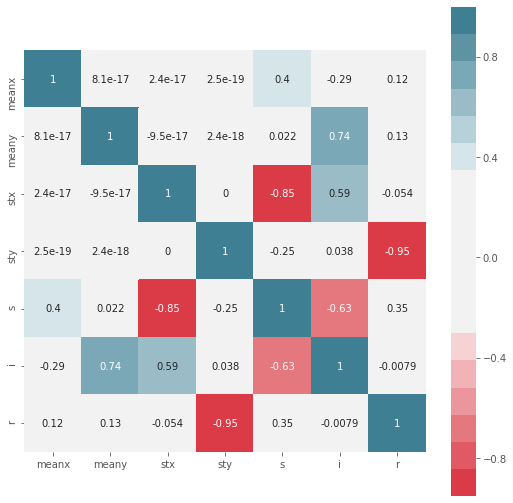

In [114]:
dfData = df.corr()
plt.subplots(figsize=(9, 9)) # 设置画面大小
sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap = sns.diverging_palette(10, 220, sep=80, n=18))
plt.savefig('./BluesStateRelation.png',dpi = 400)

## source_data


In [13]:
df = pd.read_excel("Pop_Area.xlsx",sheet_name = "Sheet3",index_col="ID")
df

,Province,City,Cities,2010Pop,2010Area,2016Pop,2016Area
ID,,,,,,,
1,上海,上海,Shanghai,2301.91,998.75,2419.70,998.75
2,北京,北京,Beijing,1685.90,NaN,1879.60,1419.66
3,重庆,重庆,Chongqing,1059.65,870.23,1453.00,1350.66
4,广东,广州,Guangzhou,869.07,952.03,1334.14,1249.11
5,广东,深圳,Shenzhen,1035.79,830.01,1190.84,923.25
6,吉林,吉林,Jilin,128.63,165.63,127.60,189.04
7,天津,天津,Tianjin,615.29,686.71,940.09,1007.91
8,湖北,武汉,Wuhan,639.73,484.01,705.75,585.61
9,四川,成都,Chengdu,433.88,455.56,690.35,837.27


$x_1 = x \times \delta$   
$\log y_1 = \log\eta+(\log y + slope \times \log\delta)  $

0.13081706109598865 0.012310793681442979
0.028026341068329737 -0.12233802043237227 0.2119255753592895


(0.9069832451489056, <matplotlib.axes._subplots.AxesSubplot at 0x2723d1354e0>)

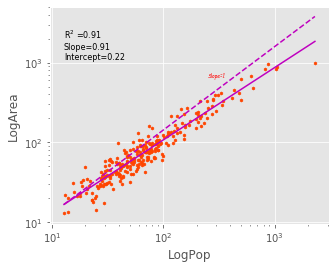

In [14]:
ls  = dropna(df,[3,4])
x1=ls[:,0]
y1=ls[:,1]
loglogplot(x1,y1)

0.13159456801686245 0.010275004698434367
0.034562774668934614 -0.16200147663999265 0.2600139535894781


(0.8812627256154176, <matplotlib.axes._subplots.AxesSubplot at 0x2723d1350f0>)

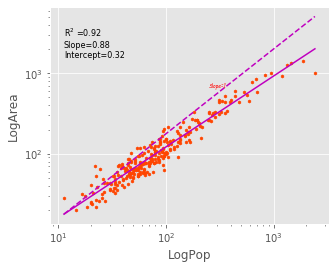

In [15]:
ls  = dropna(df,[5,6])
x2=ls[:,0]
y2=ls[:,1]
loglogplot(x2,y2)

In [18]:
delta = [xx1/xx for xx1,xx in zip(x2,x1)]
np.std(delta),np.mean(delta)

(0.5675440290369524, 1.2821820948340992)

In [19]:
slope,i,r = getslope(x1,y1)
eta = [10**(np.log10(yy1) -np.log10(yy)-slope*np.log10(deltaa))  for yy1,yy,deltaa in zip(y2,y1,delta)]
np.std(eta),np.mean(eta)

(0.49618489892636625, 1.2105833502113226)

In [20]:
eta = [yy1/((deltaa**slope)*yy) for yy1,yy,deltaa in zip(y2,y1,delta)]
np.std(eta),np.mean(eta)

(0.4961848989263662, 1.2105833502113226)

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


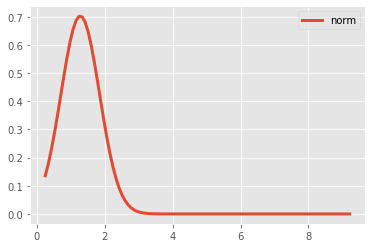

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted alpha distribution with error=1.2391717051114213)
Fitted anglit distribution with error=6.675403956950383)
Fitted arcsine distribution with error=13.419962366645636)
Fitted argus distribution with error=13.379204704324478)
Fitted beta distribution with error=3.499620092779051)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=1.557896337457859)
Fitted bradford distribution with error=11.861299466676622)
Fitted burr distribution with error=0.5158253788833321)
Fitted burr12 distribution with error=0.27545708265370317)
Fitted cauchy distribution with error=1.2875485299019722)
Fitted chi distribution with error=4.676911555631134)
Fitted chi2 distribution with error=2.6080394950514907)
Fitted cosine distribution with error=5.358835211781384)
Fitted crystalball distribution with error=5.908367913210708)
Fitted dgamma distribution with error=1.8598645222426566)
Fitted dweibull distribution with error=1.3840535849418574)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00041666666666666664.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarn

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.6019195744287245.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.6020052570074419.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.6019409950734038.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.6018195630403309.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarn

Fitted erlang distribution with error=12.294704897148645)
Fitted expon distribution with error=11.48948272926052)
Fitted exponnorm distribution with error=0.5905928247125504)
Fitted exponpow distribution with error=10.248965835430576)
Fitted exponweib distribution with error=1.6444029620900085)
Fitted f distribution with error=1.5577383140536571)
Fitted fatiguelife distribution with error=2.1808812337895853)
Fitted fisk distribution with error=0.7713883657690841)
Fitted foldcauchy distribution with error=1.2526547834600317)
Fitted foldnorm distribution with error=6.13323515112059)
Fitted frechet_l distribution with error=1.5671913102947392)
Fitted frechet_r distribution with error=6.3508531467457106)
Fitted gamma distribution with error=2.608032529883635)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3175: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


Fitted gausshyper distribution with error=12.850628067249255)
Fitted genexpon distribution with error=7.337954495369859)
Fitted genextreme distribution with error=1.6463847064347816)
Fitted gengamma distribution with error=2.324977309474272)
Fitted genhalflogistic distribution with error=9.769942005035778)
Fitted genlogistic distribution with error=0.9161920939187993)
Fitted gennorm distribution with error=1.4828380757505957)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=11.08755730726769)
Fitted gilbrat distribution with error=9.747106893705567)
Fitted gompertz distribution with error=9.472763533442354)
Fitted gumbel_l distribution with error=11.31196127616522)
Fitted gumbel_r distribution with error=1.6028881786182763)
Fitted halfcauchy distribution with error=10.886629967004998)
Fitted halfgennorm distribution with error=9.581080505502676)
Fitted halflogistic distribution with error=10.053528181982788)
Fitted halfnorm distribution with error=9.532572175413998)
Fitted hypsecant distribution with error=1.3905469373311141)
Fitted invgamma distribution with error=1.5577705728897229)
Fitted invgauss distribution with error=2.1709952606672727)
Fitted invweibull distribution with error=1.6464083845461224)
Fitted johnsonsb distribution with error=1.8395931733124495)
Fitted johnsonsu distribution with error=0.31182838019680015)
Fitted kappa3 distribution with error=8.031974320805013)
Fitted kappa4 distribution with er

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=nan)
Fitted kstwobign distribution with error=3.8472436125213654)
Fitted laplace distribution with error=1.1703511366959725)
Fitted levy distribution with error=11.1105137657948)
Fitted levy_l distribution with error=13.913263204340836)
SKIPPED levy_stable distribution (taking more than 30 seconds)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted loggamma distribution with error=6.312096387908322)
Fitted logistic distribution with error=1.7112041016039823)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


Fitted loglaplace distribution with error=0.8601177437192623)
Fitted lognorm distribution with error=1.83175638000308)
Fitted lomax distribution with error=11.49487571631806)
Fitted maxwell distribution with error=4.855069967493297)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted mielke distribution with error=0.9276592062236172)
Fitted moyal distribution with error=2.487979245770169)
Fitted nakagami distribution with error=4.6769142955107865)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


Fitted ncf distribution with error=2.303208806287166)
Fitted nct distribution with error=0.2679064052728273)
Fitted ncx2 distribution with error=2.608033450125143)
Fitted norm distribution with error=5.908367591041055)
Fitted norminvgauss distribution with error=0.40030207638112864)
Fitted pareto distribution with error=11.510587022527153)
Fitted pearson3 distribution with error=2.608652416079238)
Fitted powerlaw distribution with error=12.800104282260042)
Fitted powerlognorm distribution with error=1.7285213720314896)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5726: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5726: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))


Fitted powernorm distribution with error=nan)
Fitted rayleigh distribution with error=6.147623049658679)
Fitted rdist distribution with error=2.225363999951185)
Fitted recipinvgauss distribution with error=2.185489724124517)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5881: RuntimeWarning: invalid value encountered in log
  self.d = np.log(b*1.0 / a)


Fitted reciprocal distribution with error=14.844289027019606)
Fitted rice distribution with error=6.147510467117906)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=7.970083759947369)
Fitted skewnorm distribution with error=3.1741994477057367)
Fitted t distribution with error=0.968865605074316)
Fitted trapz distribution with error=14.66658546050063)
Fitted triang distribution with error=11.366385676466594)
Fitted truncexpon distribution with error=12.14644225297881)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


Fitted truncnorm distribution with error=9.510729317883483)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


Fitted tukeylambda distribution with error=1.673148917380351)
Fitted uniform distribution with error=13.145421812197764)
Fitted vonmises distribution with error=9.401623747327491e+61)
Fitted vonmises_line distribution with error=1.5940191110992086)
Fitted wald distribution with error=9.113735093990103)
Fitted weibull_max distribution with error=1.5671913102947392)
Fitted weibull_min distribution with error=6.3508531467457106)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


Fitted wrapcauchy distribution with error=nan)


,sumsquare_error
nct,0.267906
burr12,0.275457
johnsonsu,0.311828
norminvgauss,0.400302
burr,0.515825


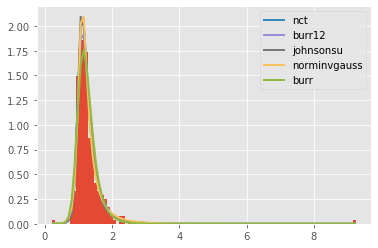

In [160]:
from fitter import Fitter
f = Fitter(delta)
#,distributions=['norm']
f.fit()
f.summary()

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


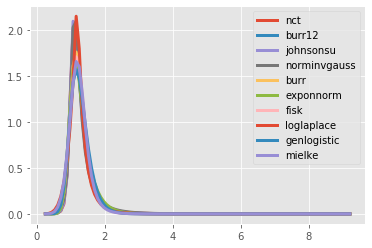

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


In [162]:
f.plot_pdf(Nbest=10, lw=3)

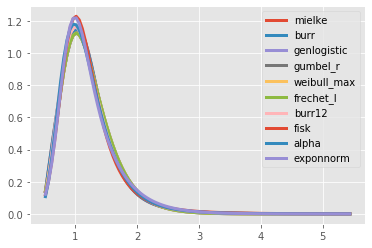

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: Integra

In [163]:
d.plot_pdf(Nbest=10, lw=3)

In [40]:
f.fitted_param['norm']

(1.2821820948340992, 0.5675440290369524)

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=0.9245914649850593)
Fitted anglit distribution with error=7.273765093564347)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted arcsine distribution with error=13.993252143549006)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:7115: RuntimeWarning: divide by zero encountered in double_scalars
  return chi**3 / (_norm_pdf_C * _argus_phi(chi)) * x * np.sqrt(y) * np.exp(-chi**2 * y / 2)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted argus distribution with error=22.312433568125932)
Fitted beta distribution with error=1.1156644390449069)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=0.9745697674426665)
Fitted bradford distribution with error=9.294510209159924)
Fitted burr distribution with error=0.8383108623663151)
Fitted burr12 distribution with error=0.8838563521104513)
Fitted cauchy distribution with error=1.9134497540629325)
Fitted chi distribution with error=1.595845859401247)
Fitted chi2 distribution with error=1.0887956400349952)
Fitted cosine distribution with error=10.383051814256461)
Fitted crystalball distribution with error=2.455818733913462)
Fitted dgamma distribution with error=1.098934407940042)
Fitted dweibull distribution with error=1.3614428089237185)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00041666666666666664.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarn

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.5033673008857054.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.5102353666728765.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.60561198514981.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.7232071104788682.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarnin

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.3975691587152341.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.3721006784328567.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.3805352147681893.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.3566283438940738.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarn

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.058223117345986.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.1611353839210103.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.0566747808569814.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.12373462208466.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning

Fitted erlang distribution with error=1.0888031013393829)
Fitted expon distribution with error=6.603364216424228)
Fitted exponnorm distribution with error=0.9333119344346306)
Fitted exponpow distribution with error=5.501075190111116)
Fitted exponweib distribution with error=0.9906824262272693)
Fitted f distribution with error=0.972772840111325)
Fitted fatiguelife distribution with error=1.0605221244996763)
Fitted fisk distribution with error=0.8981873438853563)
Fitted foldcauchy distribution with error=1.3405471920790089)
Fitted foldnorm distribution with error=3.5846858669398274)
Fitted frechet_l distribution with error=0.8798822779012309)
Fitted frechet_r distribution with error=1.5347422565930644)
Fitted gamma distribution with error=1.0888132266664257)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3175: RuntimeWarning: invalid value encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted gausshyper distribution with error=1.6158695522899431)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2315: RuntimeWarning: invalid value encountered in sqrt
  Shat = sqrt(mu2hat / mu2)


Fitted genexpon distribution with error=3.2345388487686275)
Fitted genextreme distribution with error=0.9722218842334135)
Fitted gengamma distribution with error=0.9713069042350236)
Fitted genhalflogistic distribution with error=5.642607750282859)
Fitted genlogistic distribution with error=0.8791645961864445)
Fitted gennorm distribution with error=1.5917330907742944)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=5.715017926143743)
Fitted gilbrat distribution with error=3.9825564868268475)
Fitted gompertz distribution with error=4.118741096252814)
Fitted gumbel_l distribution with error=7.720512114463418)
Fitted gumbel_r distribution with error=0.8797872728486925)
Fitted halfcauchy distribution with error=6.107624249373563)
Fitted halfgennorm distribution with error=3.689437395024171)
Fitted halflogistic distribution with error=4.168834783671293)
Fitted halfnorm distribution with error=3.584763652801344)
Fitted hypsecant distribution with error=1.2339722722174356)
Fitted invgamma distribution with error=0.9742797508408882)
Fitted invgauss distribution with error=1.0576828101754097)
Fitted invweibull distribution with error=0.972314655129634)
Fitted johnsonsb distribution with error=1.014285200771523)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted johnsonsu distribution with error=0.9917477510273393)
Fitted kappa3 distribution with error=2.7083423448744357)
Fitted kappa4 distribution with error=8.075969987018414)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=nan)
Fitted kstwobign distribution with error=1.0911739825707696)
Fitted laplace distribution with error=1.602352831532077)
Fitted levy distribution with error=6.951126671375781)
Fitted levy_l distribution with error=15.077509823859012)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


SKIPPED levy_stable distribution (taking more than 30 seconds)
Fitted loggamma distribution with error=2.5160485770507215)
Fitted logistic distribution with error=1.329890169863189)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


Fitted loglaplace distribution with error=1.4174852805635325)
Fitted lognorm distribution with error=1.0106463778801058)
Fitted lomax distribution with error=6.845305700879541)
Fitted maxwell distribution with error=1.6098427327970448)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted mielke distribution with error=0.8383105343232778)
Fitted moyal distribution with error=1.0377657835581486)
Fitted nakagami distribution with error=1.5958032587081055)
Fitted ncf distribution with error=1.726490535953148)
Fitted nct distribution with error=0.9424441243117054)
Fitted ncx2 distribution with error=1.088800602469402)
Fitted norm distribution with error=2.455818165783496)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


Fitted norminvgauss distribution with error=1.0627551703727343)
Fitted pareto distribution with error=6.5952357405823285)
Fitted pearson3 distribution with error=1.088814178437546)
Fitted powerlaw distribution with error=10.932216735014539)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted powerlognorm distribution with error=1.0140393498956128)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5726: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5726: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))


Fitted powernorm distribution with error=nan)
Fitted rayleigh distribution with error=1.458434213345979)
Fitted rdist distribution with error=2.493103117773919)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


Fitted recipinvgauss distribution with error=1.0616024519550704)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5881: RuntimeWarning: invalid value encountered in log
  self.d = np.log(b*1.0 / a)


Fitted reciprocal distribution with error=6.248592401996881)
Fitted rice distribution with error=1.4581803188816962)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=8.604761439994343)
Fitted skewnorm distribution with error=1.449565199700048)
Fitted t distribution with error=1.2040776267591076)
Fitted trapz distribution with error=17.3290228667269)
Fitted triang distribution with error=8.355087116874538)
Fitted truncexpon distribution with error=10.178646198478003)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


Fitted truncnorm distribution with error=5.4031442270149554)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


Fitted tukeylambda distribution with error=5.5297508696364455)
Fitted uniform distribution with error=12.580242865154707)
Fitted vonmises distribution with error=8.714471947149023e+60)
Fitted vonmises_line distribution with error=1.938739378792979)
Fitted wald distribution with error=3.5577077688669716)
Fitted weibull_max distribution with error=0.8798822779012309)
Fitted weibull_min distribution with error=1.5347422565930644)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


Fitted wrapcauchy distribution with error=nan)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


,sumsquare_error
mielke,0.838311
burr,0.838311
genlogistic,0.879165
gumbel_r,0.879787
weibull_max,0.879882


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


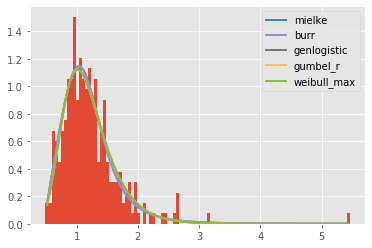

In [161]:
d = Fitter(eta)
#distributions=['norm']
d.fit()
d.summary()

In [43]:
d.fitted_param['norm']

(1.2105833502113226, 0.49618489892636625)

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


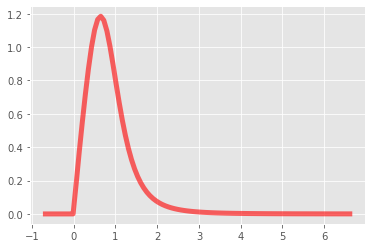

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: Integra

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: Integra

In [34]:
from scipy.stats import burr
fig, ax = plt.subplots(1, 1)
c, d = 3.8, 0.5
loc ,scale = 0.5,0.7
x = np.linspace(burr.ppf(0.001, c, d),burr.ppf(0.999, c, d), 100)
x1 = (x-loc)/scale
ax.plot(x1, 1.2*burr.pdf(x1, c, d),'r-', lw=5, alpha=0.6, label='burr pdf')

In [155]:
scipy.stats.gamma.fit(delta)

(10.404361162339885, 0.09736950291800422, 0.113876561788504)

(array([10., 48., 79., 72., 51., 21., 10.,  8.,  0.,  1.]),
 array([0.37326076, 0.56498767, 0.75671458, 0.94844149, 1.1401684 ,
        1.3318953 , 1.52362221, 1.71534912, 1.90707603, 2.09880294,
        2.29052985]),
 <a list of 10 Patch objects>)

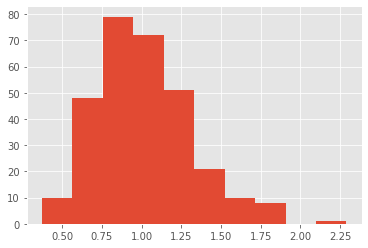

In [160]:
k,loc,scala = scipy.stats.gamma.fit(delta)
plt.hist(np.random.gamma(k,loc,300))

In [157]:
a,b,loc,scala = scipy.stats.beta.fit(delta)
a,b,loc,scala 

(7.2243677904685555,
 311587319000.08435,
 0.14632297953419465,
 49823205576.29007)

In [144]:
demo = np.random.beta(a,b,300)*scala+loc
np.mean(demo)

1.2935589526253704

(array([15., 52., 60., 65., 45., 34., 18.,  5.,  4.,  2.]),
 array([0.50596636, 0.73057946, 0.95519256, 1.17980565, 1.40441875,
        1.62903185, 1.85364494, 2.07825804, 2.30287114, 2.52748423,
        2.75209733]),
 <a list of 10 Patch objects>)

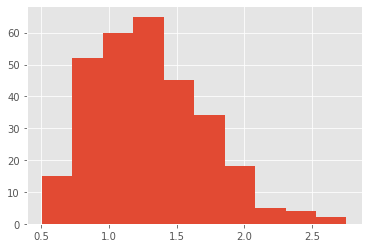

In [145]:
plt.hist(np.random.beta(a,b,300)*scala+loc)

### R2 与 stdy画图

In [95]:
df1 = pd.read_csv('sty_r2-demo1.csv')
df1=df1.set_index('Unnamed: 0')
df1

,meanx,meany,stx,sty,s,i,r
Unnamed: 0,,,,,,,
0,1.28,1.21,0.001,0.000010,0.906981,0.299599,0.910
1,1.28,1.21,0.001,0.000011,0.906981,0.299599,0.910
2,1.28,1.21,0.001,0.000013,0.906981,0.299599,0.910
3,1.28,1.21,0.001,0.000014,0.906981,0.299599,0.910
4,1.28,1.21,0.001,0.000016,0.906981,0.299599,0.910
5,1.28,1.21,0.001,0.000018,0.906980,0.299599,0.910
6,1.28,1.21,0.001,0.000020,0.906980,0.299599,0.910
7,1.28,1.21,0.001,0.000023,0.906980,0.299599,0.910
8,1.28,1.21,0.001,0.000025,0.906980,0.299599,0.910


Text(0.5, 0, '$Std Y$')

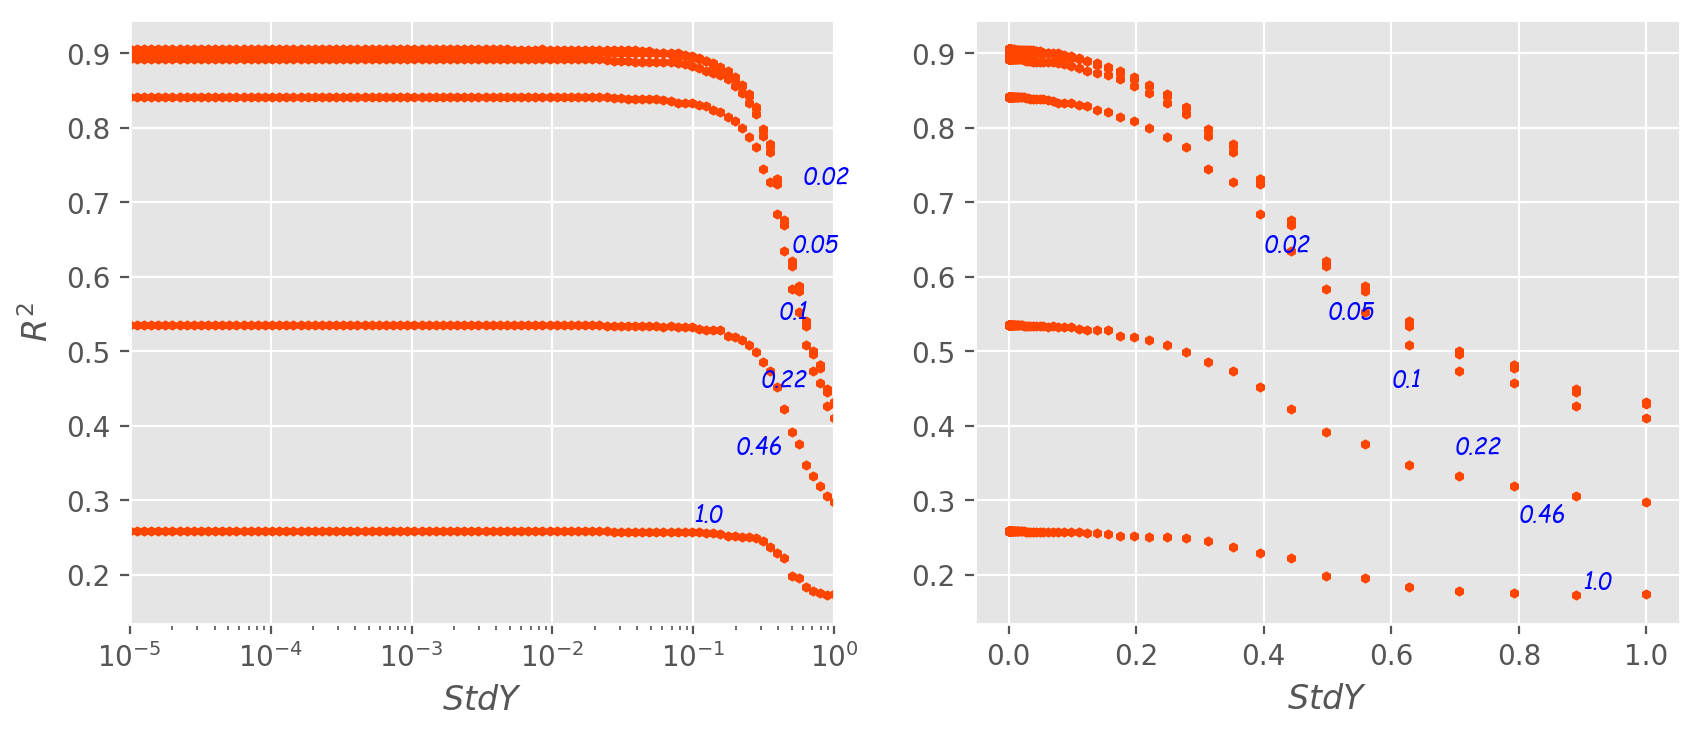

In [159]:
plt.style.use('ggplot')
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(10,4),dpi=200)
x = df1.iloc[:100,3]
n=10
y ={}
ax1.set_xscale("log")
ax1.set_xlim(1e-5,1e0)
for i in range(4,n):
    y[i]= df1.iloc[100*i:100*(i+1),6]
    stdx = df1.iloc[100*i,2]
    stdx = round(stdx,2)
    ax1.scatter(x, y[i], s=10, alpha=1, marker='h',color="orangered")
    ax1.text((1-i/10)*max(x),(1-(i-2)/10)*max(y[4]),"{}".format(stdx), fontsize=8,family = "fantasy", color = "b", style = "italic", weight = "light",)
    
    ax2.scatter(x, y[i], s=10, alpha=1, marker='h',color="orangered")
    ax2.text((i/10)*max(x),(1-(i-1)/10)*max(y[4]),"{}".format(stdx), fontsize=8,family = "fantasy", color = "b", style = "italic", weight = "light")
    
ax1.set_xlabel("$Std Y$")
ax1.set_ylabel("$R^2$")
ax2.set_xlabel("$Std Y$")

### 差值

In [18]:
de = [xx1-xx for xx1,xx in zip(x2,x1)]
np.std(de),np.mean(de)

(104.20504856151796, 32.417265917603)

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=0.00016448878143247037)
Fitted anglit distribution with error=0.00011808884652441368)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted arcsine distribution with error=0.00012581738757120147)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


Fitted argus distribution with error=0.00010962742772542223)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=5.8031273252241296e-05)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=9.700949770879115e-05)
Fitted bradford distribution with error=0.00012218334092096604)
Fitted burr distribution with error=0.0001551160497983658)
Fitted burr12 distribution with error=0.00017251634609987226)
Fitted cauchy distribution with error=4.5320653387737185e-06)
Fitted chi distribution with error=0.00013489520498946518)
Fitted chi2 distribution with error=0.00013488564927813945)
Fitted cosine distribution with error=0.00011377307214360677)
Fitted crystalball distribution with error=3.718754227166478e-05)
Fitted dgamma distribution with error=0.0001041067887276433)
Fitted dweibull distribution with error=1.5056350457332858e-05)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.000462962962962963.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarnin

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.003114743236701245.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.003090943101664366.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.003094258138239293.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.003097420134860444.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: Run

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00280882511819564.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.002785049672412984.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0026700427189305168.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0026177161439492084.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: Ru

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.999238891392918e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.907839041585083e-07.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.074661548268194e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 8.499772044920915e-06.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651:

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.9333000603088948e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.8610527477497904e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.753313240325501e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.380424859315144e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:265

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.471162067323078e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.577584733817281e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.659139378510114e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.60476961538156e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: 

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.0212660872644773e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.0078370208064724e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.4830004328228074e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.3168330583406067e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.5593628327525e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.556840166318744e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.5828542559950205e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.5561781479642497e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651:

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.540899425123661e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.47411798999547e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.4774366100813392e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.4934886965167534e-05.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651

Fitted erlang distribution with error=0.00013489518720384105)
Fitted expon distribution with error=0.0001303461792476258)
Fitted exponnorm distribution with error=6.045893072539632e-05)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:1415: RuntimeWarning: divide by zero encountered in log
  return exparg + np.log(0.5 * invK * sc.erfc(-(x - invK) / np.sqrt(2)))


Fitted exponpow distribution with error=0.00013489520498946518)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted exponweib distribution with error=0.00016022592970299453)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:1680: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)


Fitted f distribution with error=0.0001591878656101868)
Fitted fatiguelife distribution with error=0.00013666559770392545)
Fitted fisk distribution with error=0.0001484627550896522)
Fitted foldcauchy distribution with error=9.589782250007667e-05)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted foldnorm distribution with error=0.00013489520498946518)
Fitted frechet_l distribution with error=0.00014452701602538272)
Fitted frechet_r distribution with error=0.0001437057343479357)
Fitted gamma distribution with error=0.0001348914534185505)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3175: RuntimeWarning: invalid value encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


Fitted gausshyper distribution with error=9.117774906195206e-05)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


Fitted genexpon distribution with error=0.00012267616730375495)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2365: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


Fitted genextreme distribution with error=0.00014024506177689165)
Fitted gengamma distribution with error=0.00013137695755204593)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2781: RuntimeWarning: divide by zero encountered in power
  tmp0 = tmp**(limit-1)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2782: RuntimeWarning: invalid value encountered in multiply
  tmp2 = tmp0*tmp


Fitted genhalflogistic distribution with error=0.00011598969810583557)
Fitted genlogistic distribution with error=2.674398212931766e-05)
Fitted gennorm distribution with error=4.530489633714693e-06)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=0.00017502696601683925)
Fitted gilbrat distribution with error=0.00012716875831326923)
Fitted gompertz distribution with error=0.00013489520498946518)
Fitted gumbel_l distribution with error=6.941268899621484e-05)
Fitted gumbel_r distribution with error=0.00010259848483345734)
Fitted halfcauchy distribution with error=0.0001290825078382188)
Fitted halfgennorm distribution with error=0.0001413595420622611)
Fitted halflogistic distribution with error=0.00012795382291254154)
Fitted halfnorm distribution with error=0.00012761804997105477)
Fitted hypsecant distribution with error=1.9958221897814323e-05)
Fitted invgamma distribution with error=6.995172835994288e-05)
Fitted invgauss distribution with error=0.00013176011807502548)
Fitted invweibull distribution with error=0.00015550126199967348)
Fitted johnsonsb distribution with error=5.534956204991874e-05)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted johnsonsu distribution with error=2.9688110210269915e-06)
Fitted kappa3 distribution with error=0.00015207022932904078)
Fitted kappa4 distribution with error=0.0001196181546951508)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=nan)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted kstwobign distribution with error=0.00013489520498946518)
Fitted laplace distribution with error=1.1872779570840513e-05)
Fitted levy distribution with error=0.0001296161981761384)
Fitted levy_l distribution with error=0.00011813706135897203)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


SKIPPED levy_stable distribution (taking more than 30 seconds)
Fitted loggamma distribution with error=5.43328403601589e-05)
Fitted logistic distribution with error=2.6642848071217883e-05)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4290: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


Fitted loglaplace distribution with error=0.00014898417807908957)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


Fitted lognorm distribution with error=0.00014958087438758934)
Fitted lomax distribution with error=0.00012793561940468838)
Fitted maxwell distribution with error=0.00013489520498946518)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=

Fitted mielke distribution with error=0.0001232131230225729)
Fitted moyal distribution with error=7.970185703822696e-05)
Fitted nakagami distribution with error=0.00013489520498946518)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


Fitted ncf distribution with error=0.00013241721574813208)
Fitted nct distribution with error=3.1295308623164225e-06)
Fitted ncx2 distribution with error=7.477960453044794e-05)
Fitted norm distribution with error=6.045234226029195e-05)
Fitted norminvgauss distribution with error=5.048666706230017e-06)
Fitted pareto distribution with error=0.0001817211408576357)
Fitted pearson3 distribution with error=5.611856068047701e-05)
Fitted powerlaw distribution with error=0.00011481476525227564)
Fitted powerlognorm distribution with error=0.00016713533232644594)
Fitted powernorm distribution with error=5.621669392817521e-05)
Fitted rayleigh distribution with error=0.00012045591178845372)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5773: RuntimeWarning: divide by zero encountered in power
  return np.power((1.0 - x**2), c / 2.0 - 1) / sc.beta(0.5, c / 2.0)


Fitted rdist distribution with error=0.00015722378544393172)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: Integra

SKIPPED recipinvgauss distribution (taking more than 30 seconds)
Fitted reciprocal distribution with error=0.00013489520498946518)
Fitted rice distribution with error=0.00013489520498946518)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=0.0001211372657194665)
Fitted skewnorm distribution with error=5.679404028906084e-05)
Fitted t distribution with error=4.117594716952594e-06)
Fitted trapz distribution with error=0.00011464283954902922)
Fitted triang distribution with error=0.00010570573417939945)
Fitted truncexpon distribution with error=0.00012689289442529314)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


Fitted truncnorm distribution with error=0.00013489520498946518)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


Fitted tukeylambda distribution with error=4.011228899797412e-06)
Fitted uniform distribution with error=0.0001221833156722227)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


SKIPPED vonmises distribution (taking more than 30 seconds)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


SKIPPED vonmises_line distribution (taking more than 30 seconds)
Fitted wald distribution with error=0.00012601444677857378)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


Fitted weibull_max distribution with error=0.00014452701602538272)
Fitted weibull_min distribution with error=0.0001437057343479357)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


Fitted wrapcauchy distribution with error=nan)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2315: RuntimeWarning: invalid value encountered in sqrt
  Shat = sqrt(mu2hat / mu2)


,sumsquare_error
johnsonsu,0.000003
nct,0.000003
tukeylambda,0.000004
t,0.000004
gennorm,0.000005


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: Integra

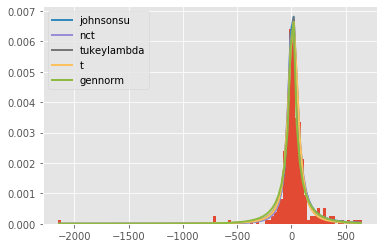

In [169]:
d = Fitter(de)
#distributions=['norm']
d.fit()
d.summary()

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


,sumsquare_error
johnsonsu,0.000003
nct,0.000003
tukeylambda,0.000004
t,0.000004
gennorm,0.000005
cauchy,0.000005
norminvgauss,0.000005
laplace,0.000012
dweibull,0.000015
hypsecant,0.000020


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


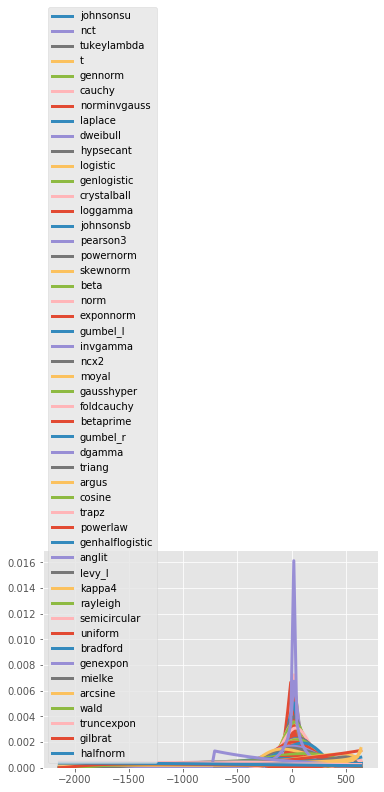

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


In [173]:
d.summary(Nbest=50, lw=3)

In [21]:
slope,i,r = getslope(x1,y1)
et = [yy1-(xx1/xx)**slope*yy for yy1,yy,xx1,xx,deltaa in zip(y2,y1,x2,x1,de)]
np.std(et),np.mean(et)

(58.100987723890015, 12.467425253296069)

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=0.0010483778583100702)
Fitted anglit distribution with error=0.0009523293469852326)
Fitted arcsine distribution with error=0.0013324293813890059)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted argus distribution with error=0.0010520450156042346)
Fitted beta distribution with error=0.00037422209088387883)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=0.0004606026438345876)
Fitted bradford distribution with error=0.001125018475648738)
Fitted burr distribution with error=0.0020963389174139015)
Fitted burr12 distribution with error=0.0012007941093310126)
Fitted cauchy distribution with error=6.816466667771642e-05)
Fitted chi distribution with error=0.0013437247977178966)
Fitted chi2 distribution with error=0.0013458772388013724)
Fitted cosine distribution with error=0.0008506450338342184)
Fitted crystalball distribution with error=0.0003122245662457841)
Fitted dgamma distribution with error=0.00011681333902635765)
Fitted dweibull distribution with error=0.00012882287800320135)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 14.700000000000001.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 14.466666666666669.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 14.700000000000003.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 14.933333333333337.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarn

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 41.89671207941191.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 40.44942176290468.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 37.88859735956149.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 43.158920042079004.
  RuntimeWarning)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2651: RuntimeWarning

Fitted erlang distribution with error=0.00043271640033737825)
Fitted expon distribution with error=0.0012310153363011978)
Fitted exponnorm distribution with error=0.000306441278414266)
Fitted exponpow distribution with error=0.0013837265115250943)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:1469: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:1680: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)


Fitted exponweib distribution with error=0.0017178847800781503)
Fitted f distribution with error=0.0020718632684744724)
Fitted fatiguelife distribution with error=0.0006131319291215619)
Fitted fisk distribution with error=0.001872267095348208)
Fitted foldcauchy distribution with error=0.008840916845458497)
Fitted foldnorm distribution with error=0.001343676616999545)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted frechet_l distribution with error=0.0015996750342911774)
Fitted frechet_r distribution with error=0.0016298588026185431)
Fitted gamma distribution with error=0.00039864709360199315)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


Fitted gausshyper distribution with error=10342.369688450006)
Fitted genexpon distribution with error=0.0012310432429659072)
Fitted genextreme distribution with error=0.0010770399759310798)
Fitted gengamma distribution with error=0.001230352658367122)
Fitted genhalflogistic distribution with error=0.0010433493583191517)
Fitted genlogistic distribution with error=0.00016039148493494717)
Fitted gennorm distribution with error=7.094502476089694e-05)
Fitted genpareto distribution with error=0.0022055787561253183)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted gilbrat distribution with error=0.0011505752599452381)
Fitted gompertz distribution with error=0.001343676616999545)
Fitted gumbel_l distribution with error=0.0007079597615203226)
Fitted gumbel_r distribution with error=0.0006534133155457918)
Fitted halfcauchy distribution with error=0.001196352450542005)
Fitted halfgennorm distribution with error=0.0014689296089370424)
Fitted halflogistic distribution with error=0.0011707662201250067)
Fitted halfnorm distribution with error=0.0011613056458117568)
Fitted hypsecant distribution with error=0.00011653956059858924)
Fitted invgamma distribution with error=0.00038145240724334664)
Fitted invgauss distribution with error=0.0009906377653035457)
Fitted invweibull distribution with error=0.002098437050037281)
Fitted johnsonsb distribution with error=0.00037531546726896054)
Fitted johnsonsu distribution with error=5.027468473613612e-05)
Fitted kappa3 distribution with error=0.0019838548807608815)
Fitted kappa4 distribution with error=0.0011

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=nan)
Fitted kstwobign distribution with error=0.001343676616999545)
Fitted laplace distribution with error=8.090345414840025e-05)
Fitted levy distribution with error=0.001206905982100481)
Fitted levy_l distribution with error=0.0012107827660072941)
SKIPPED levy_stable distribution (taking more than 30 seconds)
Fitted loggamma distribution with error=0.00039199231714090953)
Fitted logistic distribution with error=0.00016034142042225155)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4290: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


Fitted loglaplace distribution with error=0.001967578935763929)
Fitted lognorm distribution with error=0.001771350064490606)
Fitted lomax distribution with error=0.002401215459762997)
Fitted maxwell distribution with error=0.001343676616999545)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4578: RuntimeWarning: overflow encountered in power
  return k*x**(k-1.0) / (1.0+x**s)**(1.0+k*1.0/s)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4578: RuntimeWarning: overflow encountered in multiply
  return k*x**(k-1.0) / (1.0+x**s)**(1.0+k*1.0/s)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:4578: RuntimeWarning: invalid value encountered in true_divide
  retur

Fitted mielke distribution with error=0.0006752472785837376)
Fitted moyal distribution with error=0.0007743744209180206)
Fitted nakagami distribution with error=0.001343676616999545)
Fitted ncf distribution with error=0.002228166191603131)
Fitted nct distribution with error=4.8925119457468504e-05)
Fitted ncx2 distribution with error=0.0013760184237882026)
Fitted norm distribution with error=0.000375313926854923)
Fitted norminvgauss distribution with error=8.95237866380974e-05)
Fitted pareto distribution with error=0.0024021649904326452)
Fitted pearson3 distribution with error=0.0003724787441859972)
Fitted powerlaw distribution with error=0.001119702987233029)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2315: RuntimeWarning: invalid value encountered in sqrt
  Shat = sqrt(mu2hat / mu2)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5689: RuntimeWarning: divide by zero encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5689: RuntimeWarning: overflow encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5689: RuntimeWarning: invalid value encountered in multiply
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))


Fitted powerlognorm distribution with error=0.0014986928992893117)
Fitted powernorm distribution with error=0.00037535050411856074)
Fitted rayleigh distribution with error=0.0009863187524573964)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:5773: RuntimeWarning: divide by zero encountered in power
  return np.power((1.0 - x**2), c / 2.0 - 1) / sc.beta(0.5, c / 2.0)


Fitted rdist distribution with error=0.0011586459955999996)
Fitted recipinvgauss distribution with error=0.00037506997480293684)
Fitted reciprocal distribution with error=0.001343676616999545)
Fitted rice distribution with error=0.001343676616999545)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=0.001034666851330851)
Fitted skewnorm distribution with error=0.00036034161452621786)
Fitted t distribution with error=4.8525869271374995e-05)
Fitted trapz distribution with error=0.001165754541251508)
Fitted triang distribution with error=0.0008513606189103699)
Fitted truncexpon distribution with error=0.0011439820368044325)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6348: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


Fitted truncnorm distribution with error=0.001343676616999545)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:6408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


Fitted tukeylambda distribution with error=4.920791523641977e-05)
Fitted uniform distribution with error=0.0011250293621506964)
Fitted vonmises distribution with error=1.5003786475439525e+56)
Fitted vonmises_line distribution with error=0.00026346171649551314)
Fitted wald distribution with error=0.0011238257975536136)
Fitted weibull_max distribution with error=0.0015996750342911774)
Fitted weibull_min distribution with error=0.0016298588026185431)
Fitted wrapcauchy distribution with error=nan)


F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\optimize\optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


,sumsquare_error
t,0.000049
nct,0.000049
tukeylambda,0.000049
johnsonsu,0.000050
cauchy,0.000068


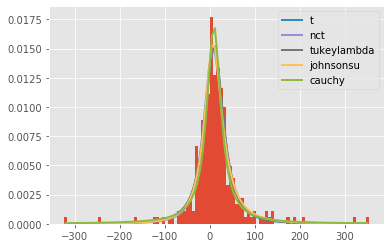

F:\Miniconda\conda64\envs\py37\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


In [24]:
w = Fitter(et)
#distributions=['norm']
w.fit()
w.summary()

## reorder dis 

0.13159456801686245 0.0007093595743351424
0.04127159397545798 -0.14797108214716667 0.14324305840248902


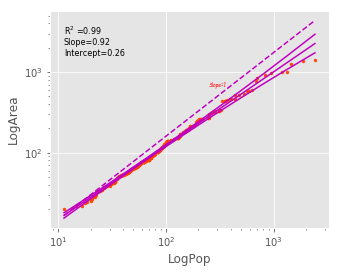

In [272]:
x2 = reorder(x1,1)
y2 = reorder(y1,1)
loglogplot(x2,y2)

0.17533527032222862 0.018031610125816618
0.07416269165586468 -0.3449593213482768 0.4626804181675696


(0.8431522532911535, <matplotlib.axes._subplots.AxesSubplot at 0x27a28d65278>)

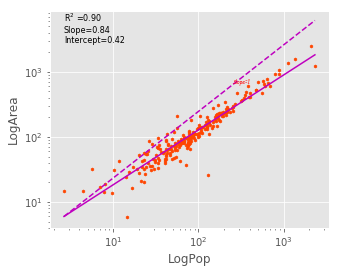

In [402]:
xr,yr = excess_incre(x,y,xp,slope)
xx,yy = del_nagative(xr,yr)
loglogplot(xx,yy)

0.13159456801686245 0.010275004698434367
0.034562774668934614 -0.16200147663999265 0.2600139535894781
<class 'numpy.float64'>


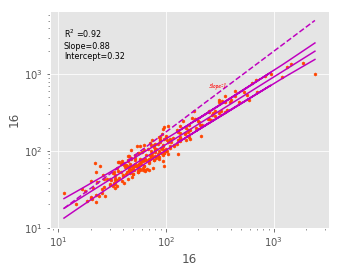

In [325]:
ls  = dropna(df,[5,6])
x1=ls[:,0]
y1=ls[:,1]
loglogplot(x1,y1,"16","16")
slope = getslope(x,y)

In [ ]:
def generate_dis():
    
    return 